In [1]:
from pathlib import Path
from datetime import datetime
import sys
import yaml
from time import time
import os
import copy
from geopy.geocoders import GoogleV3, Nominatim
import matplotlib.dates as mdates
from numpy import median

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer

import matplotlib.pyplot as plt
from matplotlib import lines

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from shapely import geometry

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
background_path = os.path.join('..', 'data', 'plot', 'background','Minnesota')
city = gpd.read_file(os.path.join(background_path, "Cities.zip")).to_crs(4326)
# lakes = gpd.read_file(os.path.join(background_path, "Rivers.zip")).to_crs(4326)
# street = gpd.read_file(os.path.join(background_path, "Roads.zip")).to_crs(4326)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

In [3]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'minneapolist_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [4]:
import math

def get_sigmoid(x):
    return 1/(1+math.e**(-x))-0.5

def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    # y = sqrt(x), sigmoid, saturated functions
    score = get_sigmoid(banks) + get_sigmoid(clinics) + get_sigmoid(hospitals) + get_sigmoid(dentists) + get_sigmoid(supermarkets)
    return score



In [5]:
temp_df = services_gdf.apply(copy.deepcopy)

epsg = findEPSG(temp_df['latitude'].iloc[0], temp_df['longitude'].iloc[0])
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y

In [6]:
from shapely.geometry import Point
city = city.to_crs(epsg)

new_census = census_gdf.to_crs(epsg).intersection(city.unary_union)
census_union = gpd.GeoDataFrame(geometry=new_census, crs=epsg)
# the number of each building in each census block
new_census = census_gdf.to_crs(epsg).copy(True)
new_census['banks'] = 0
new_census['clinics'] = 0
new_census['dentists'] = 0
new_census['hospitals'] = 0
new_census['supermarket'] = 0
for idx, row in new_census.iterrows():
    for _, service in temp_df.iterrows():
        if row.geometry.contains(Point(service.stop_x, service.stop_y)):
            new_census.loc[idx, service['service']] += 1
new_census['score'] = new_census.apply(axis=1, func=lambda row: get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket']))

In [7]:
new_census = new_census.to_crs(4326).copy(True)

In [8]:
polys = [(min_lon, min_lat), (min_lon, max_lat), (max_lon, min_lat), (max_lon, max_lat)]
s = gpd.GeoSeries(geometry.Polygon(polys).convex_hull)
res = new_census.apply(lambda row: s.contains(row['geometry'].centroid), axis=1)
new_census = new_census[res[0]]
# s.contains(new_census.centroid)

In [9]:
new_census_sorted = new_census[new_census['score'] != 0].sort_values('score')
points_low = new_census_sorted.head(10)
points_high = new_census_sorted.tail(10)

In [10]:
def flatten(s, crs):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union]), 'crs': crs})

def gen_busSim(data_path=None, out_path=None, day=None, start_time=None, elapse_time=None, avg_walking_speed=None, max_walking_min=None):
    manager = LocalManager(data_path, out_path, None)
    busSim = BusSim(manager, day, start_time, elapse_time, avg_walking_speed, max_walking_min)
    return busSim

def get_area(start_points=[], start_locations=[], busSim=None, crs=None, city=None):
    if len(start_points)==0:
        geolocator = Nominatim(user_agent="user_test")
        for loc in start_locations:
            location = geolocator.geocode(loc)
            print(location)
            start_point = (location.latitude, location.longitude)
            start_points.append(start_point)
    
    area_dict = {}
    # print(f'{start_points=}')
    for index, start in enumerate(start_points):
        # print(f'{start=}')
        gdf = busSim.get_gdf(start_point=start)
        busSim.clear_graph()
        if gdf is None:
            area_dict[f'{start_points[index]}'] = 0
            continue
        gdf = gdf.to_crs(epsg=crs)
        bubble = flatten(gdf.geometry, crs)
        new_census2 = new_census.to_crs(crs).intersection(bubble.unary_union)
        new_census2 = gpd.GeoDataFrame(geometry=new_census2, crs=crs)
        new_census2['score'] = new_census['score']
        # print(f'{new_census2.head()=}')
        area_dict[f'{start_points[index]}'] = new_census2[~new_census2['geometry'].is_empty]['score'].sum()
    # print(f'{area_dict=}')
    return area_dict

def draw_area_times(times, areas, data_path, results):
    fig, ax = plt.subplots(figsize=(12,8)) 
    times = list(map(lambda x: datetime.strptime(x.capitalize(), "%A %H:%M:%S  %d"), times))
    formatter = mdates.DateFormatter("%a %H:%M")
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate()
    
    for key in areas.keys():
        # print(f'loc {key}')
        # print(f'{areas[key]=}')
        # print(f'min value: {min(areas[key])}')
        results['min score'].append(min(areas[key]))
        results['max score'].append(max(areas[key]))
        results['median score'].append(median(areas[key]))
        # print(f'max value: {max(areas[key])}')
        geoloctor = Nominatim(user_agent="reverse_user")
        info = geoloctor.reverse(key[1:-1]).raw
        if info != None:
            info = info['address']
            addr = ''
            for index, addrkey in enumerate(info):
                if index > 1:
                    break
                addr += " " + info[addrkey]
        else:
            addr = key
        ax.plot(times, areas[key], label = addr)
        results['label'].append(addr)
    
    ax.set_ylim(bottom=0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel("score", fontsize=18)
    plt.title('Score vs Time', fontsize=20)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.savefig('mearsurement_plot.png', bbox_inches='tight')

def run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results):
    prog_start = time()
    areas = {}
    for start_time in start_times:
        # print('creat busSim')
        day, start = start_time.split(' ')
        busSim = gen_busSim(DATA_PATH,OUT_PATH, day, start, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
        # print('cal area')
        for key, area in get_area(start_points=START_POINTS, start_locations=START_LOCATIONS, busSim=busSim, crs=crs).items():
            if key not in areas:
                areas[key] = []
                areas[key].append(float(area))
            else:
                areas[key].append(float(area))
    # print(f'{areas=}')
    pre_day = ''
    day_index = 0
    for index in range(len(start_times)):
        day, start = start_times[index].split(' ')
        if pre_day != day:
            day_index+=1
            pre_day = day
        start_times[index] = f"{start_times[index]}  {day_index}"
        
    print(start_times)
    draw_area_times(start_times, areas, DATA_PATH, results)
    duration = time() - prog_start
    # results['time'].append(duration)
    print(f'time taken {duration}')
    return duration

/var/folders/v_/6c5ts29s0gd2d_5_syjrk88c0000gn/T/ipykernel_61535/2014523542.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  start_points_dict = {"low": [(p.y, p.x) for p in points_low.centroid], "high": [(p.y, p.x) for p in points_high.centroid]}
/var/folders/v_/6c5ts29s0gd2d_5_syjrk88c0000gn/T/ipykernel_61535/2014523542.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  start_points_dict = {"low": [(p.y, p.x) for p in points_low.centroid], "high": [(p.y, p.x) for p in points_high.centroid]}


len(start_points_dict["high"])=10
stops_meter exists
['monday 00:00:00  1', 'monday 03:00:00  1', 'monday 06:00:00  1', 'monday 09:00:00  1', 'monday 12:00:00  1', 'monday 15:00:00  1', 'monday 18:00:00  1', 'monday 21:00:00  1', 'tuesday 00:00:00  2', 'tuesday 03:00:00  2', 'tuesday 06:00:00  2', 'tuesday 09:00:00  2', 'tuesday 12:00:00  2', 'tuesday 15:00:00  2', 'tuesday 18:00:00  2', 'tuesday 21:00:00  2', 'wednesday 00:00:00  3', 'wednesday 03:00:00  3', 'wednesday 06:00:00  3', 'wednesday 09:00:00  3', 'wednesday 12:00:00  3', 'wednesday 15:00:00  3', 'wednesday 18:00:00  3', 'wednesday 21:00:00  3', 'thursday 00:00:00  4', 'thursday 03:00:00  4', 'thursday 06:00:00  4', 'thursday 09:00:00  4', 'thursday 12:00:00  4', 'thursday 15:00:00  4', 'thursday 18:00:00  4', 'thursday 21:00:00  4', 'friday 00:00:00  5', 'friday 03:00:00  5', 'friday 06:00:00  5', 'friday 09:00:00  5', 'friday 12:00:00  5', 'friday 15:00:00  5', 'friday 18:00:00  5', 'friday 21:00:00  5', 'saturday 00:00:00

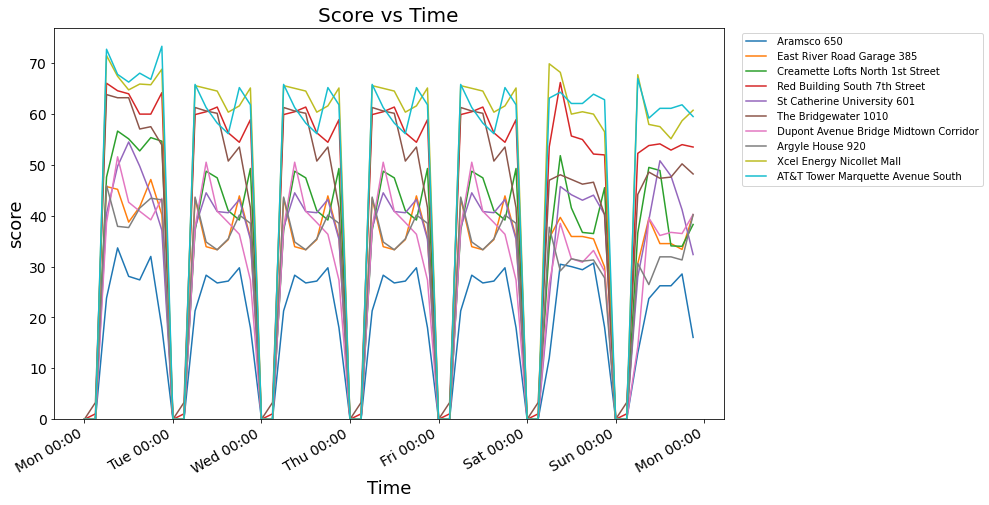

In [12]:
start_points_dict = {"low": [(p.y, p.x) for p in points_low.centroid], "high": [(p.y, p.x) for p in points_high.centroid]}
results = {
    "label":[],
    "max score": [],
    "min score": [],
    "median score": []
}

print(f'{len(start_points_dict["high"])=}')
START_POINTS = start_points_dict['high']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/minneapolist_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 26867
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(0,24,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

In [13]:
print(pd.DataFrame(results).to_markdown())

|    | label                                 |   max score |   min score |   median score |
|---:|:--------------------------------------|------------:|------------:|---------------:|
|  0 | Aramsco 650                           |     33.666  |           0 |        23.7619 |
|  1 | East River Road Garage 385            |     47.1004 |           0 |        35.2929 |
|  2 | Creamette Lofts North 1st Street      |     56.6103 |           0 |        39.1382 |
|  3 | Red Building South 7th Street         |     66.1495 |           0 |        55.2971 |
|  4 | St Catherine University 601           |     54.466  |           0 |        40.305  |
|  5 | The Bridgewater 1010                  |     63.7767 |           0 |        48.37   |
|  6 | Dupont Avenue Bridge Midtown Corridor |     51.559  |           0 |        36.3442 |
|  7 | Argyle House 920                      |     45.9418 |           0 |        34.0628 |
|  8 | Xcel Energy Nicollet Mall             |     71.4414 |           0 |      

len(start_points_dict["low"])=10
stops_meter exists
['monday 00:00:00  1', 'monday 03:00:00  1', 'monday 06:00:00  1', 'monday 09:00:00  1', 'monday 12:00:00  1', 'monday 15:00:00  1', 'monday 18:00:00  1', 'monday 21:00:00  1', 'tuesday 00:00:00  2', 'tuesday 03:00:00  2', 'tuesday 06:00:00  2', 'tuesday 09:00:00  2', 'tuesday 12:00:00  2', 'tuesday 15:00:00  2', 'tuesday 18:00:00  2', 'tuesday 21:00:00  2', 'wednesday 00:00:00  3', 'wednesday 03:00:00  3', 'wednesday 06:00:00  3', 'wednesday 09:00:00  3', 'wednesday 12:00:00  3', 'wednesday 15:00:00  3', 'wednesday 18:00:00  3', 'wednesday 21:00:00  3', 'thursday 00:00:00  4', 'thursday 03:00:00  4', 'thursday 06:00:00  4', 'thursday 09:00:00  4', 'thursday 12:00:00  4', 'thursday 15:00:00  4', 'thursday 18:00:00  4', 'thursday 21:00:00  4', 'friday 00:00:00  5', 'friday 03:00:00  5', 'friday 06:00:00  5', 'friday 09:00:00  5', 'friday 12:00:00  5', 'friday 15:00:00  5', 'friday 18:00:00  5', 'friday 21:00:00  5', 'saturday 00:00:00 

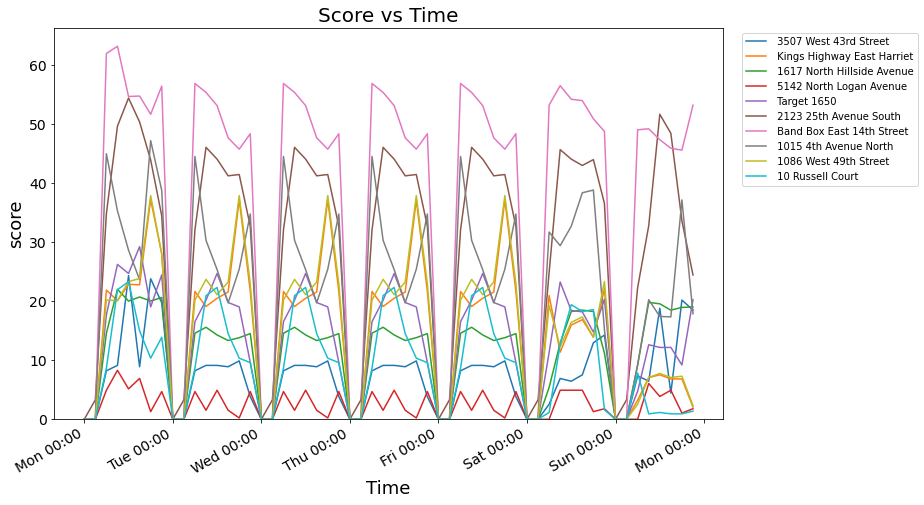

In [19]:
results1 = {
    "label":[],
    "max score": [],
    "min score": [],
    "median score": []
}

print(f'{len(start_points_dict["low"])=}')
START_POINTS = start_points_dict['low']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/minneapolist_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 26867
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(0,24,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results1))

In [20]:
print(pd.DataFrame(results1).to_markdown())

|    | label                      |   max score |   min score |   median score |
|---:|:---------------------------|------------:|------------:|---------------:|
|  0 | 3507 West 43rd Street      |    24.3569  |           0 |        8.2247  |
|  1 | Kings Highway East Harriet |    37.2356  |           0 |       19.6234  |
|  2 | 1617 North Hillside Avenue |    22.0407  |           0 |       14.2981  |
|  3 | 5142 North Logan Avenue    |     8.30602 |           0 |        1.52655 |
|  4 | Target 1650                |    29.2729  |           0 |       16.5574  |
|  5 | 2123 25th Avenue South     |    54.466   |           0 |       34.6889  |
|  6 | Band Box East 14th Street  |    63.2366  |           0 |       48.4055  |
|  7 | 1015 4th Avenue North      |    47.2459  |           0 |       25.3748  |
|  8 | 1086 West 49th Street      |    37.9288  |           0 |       20.2107  |
|  9 | 10 Russell Court           |    23.345   |           0 |        9.6007  |
